In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread,imshow
from skimage.transform import resize
from skimage.util import random_noise
from os.path import join
from os import listdir
import pickle

from keras import Model
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout
from keras.losses import binary_crossentropy
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
import keras
from keras import backend as K

Using TensorFlow backend.


In [2]:
def rgb2gray(img):
    return (0.299*img[:, :, 0] + 0.587*img[:, :, 1] + 0.114*img[:, :, 2]).astype('float32')

def show(img):
    if len(img.shape) == 3:
        height, width,_ = img.shape
    elif len(img.shape) == 2:
        height, width = img.shape
        
    img = img.reshape(height, width)
    plt.figure(figsize=(6,6))
    plt.imshow(img,cmap='gray')
    plt.show()

In [4]:
def get_data(data_path, size, amount=None):
    filenames = listdir(data_path)
    n_files = len(filenames)
    
    if amount:
        n_files = min(n_files, amount)
    
    data = np.empty((n_files,)+size)
    
    for i,file in enumerate(filenames[:n_files]):
        file_path = join(data_path, file)
        data[i] = resize(imread(file_path, as_gray=True), size)
        
    return data.reshape(data.shape+(1,))

In [5]:
def get_noisy_data(data, mode='gaussian', **kwargs):
    noisy_data = np.empty_like(data)
    
    for i in range(noisy_data.shape[0]):
        noisy_data[i] = random_noise(data[i], mode=mode)
        
    return noisy_data

## U-net

In [6]:
def build_model(size, start_neurons=8):
    input_layer = Input(size+ (1,))
    
    conv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons*16,(3,3),activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons*16,(3,3),activation="relu", padding="same")(convm)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons*4,(3,3),strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons*2,(3,3),strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons*1,(3,3),strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(uconv1)

    uncov1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1,(1,1), padding="same", activation="sigmoid")(uconv1)
    
    model = Model(input_layer, output_layer)
    return model

In [7]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return 10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true))))/K.log(10.0)

get_custom_objects().update({'PSNR': PSNR})

In [23]:
def MSE(img1, img2):
    shape = np.array(img1.shape).prod()
    res = ((img1-img2)**2).sum()/shape
    if (res == 0):
        raise ValueError
    else:
        return res

def compute_psnr(img_pred, img_gt):
    img_pred = img_pred.astype('float64')
    img_gt = img_gt.astype('float64')
    max_pixel = 1.0
    return 10*np.log10(max_pixel**2/MSE(img_pred, img_gt))

## Data

In [9]:
data_path = 'data/VOC2007/JPEGImages/'
size = (256,256)
amount = 5

clean_data = get_data(data_path, size, amount)
noisy_data = get_noisy_data(clean_data, mode='gaussian')

## N2C

In [11]:
model = build_model(size)

model.compile(loss='mse', optimizer=Adam(lr=1e-3), metrics=[PSNR])
model.load_weights('models/denoising___.hdf5')

0.9972601300737098
0.9681011029421989
0.933411724696866
1.0
0.999504196959163


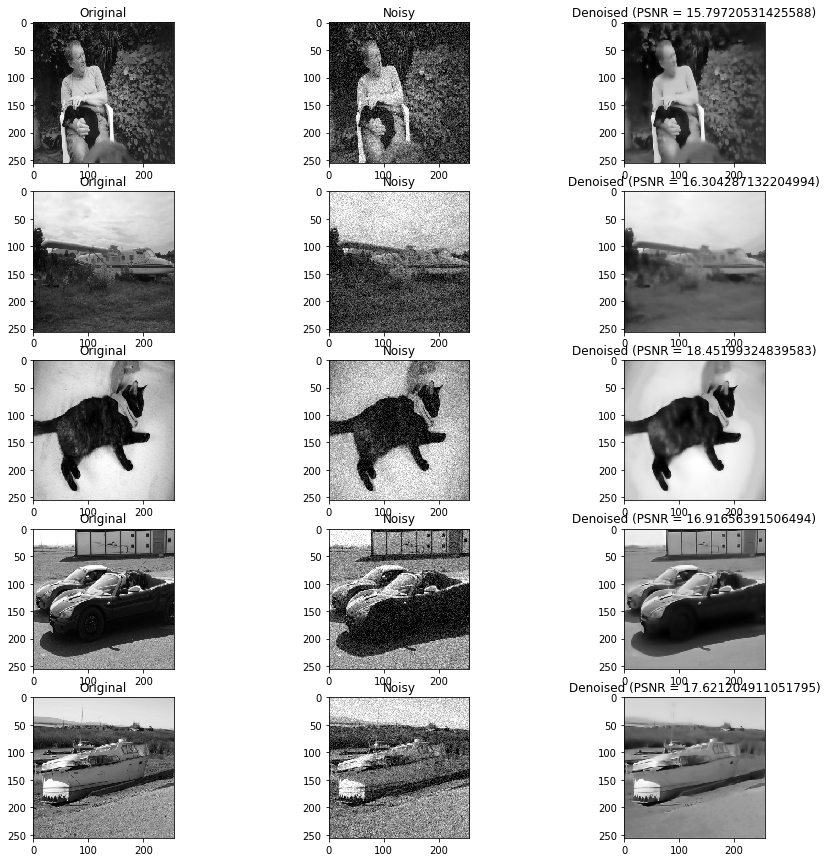

In [24]:
predict = model.predict(clean_data)

fig, axes = plt.subplots(amount, 3, figsize=(15,15))
for i in range(amount):
    orig_img = clean_data[i].reshape(size)
    axes[i,0].imshow(orig_img, cmap='gray')
    axes[i,0].set_title('Original')
    noisy_img = noisy_data[i].reshape(size)
    axes[i,1].imshow(noisy_img, cmap='gray')
    axes[i,1].set_title('Noisy')
    pred_img = predict[i].reshape(size)
    axes[i,2].imshow(pred_img,cmap='gray')
    axes[i,2].set_title('Denoised (PSNR = {})'.format(compute_psnr(pred_img, orig_img)))
    
plt.imshow()

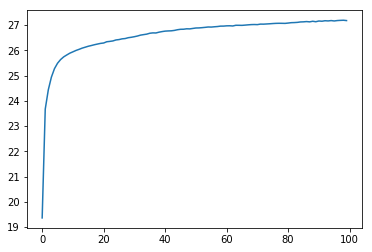

In [22]:
with open('stats/stats_n2c__.pickle', 'rb') as f:
    stats = pickle.load(f)

plt.plot(stats['PSNR'])